<a href="https://colab.research.google.com/github/dnmuturi/SIT742/blob/main/SIT742Task2code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**END TERM ASSIGNMENT**

 **GROUP C30 Members**

1. David Muturi - S225177509
2. Nhlanhla Matukane - S225177376
3. Vincent Nwobi - S225177483

### **Part 1**

In [1]:
#install the missing libraries library
!pip install pyspark
!pip install wget

In [2]:
#load necessary libraries

import warnings
warnings.filterwarnings("ignore")

#load libraries for reading in zipped file from github
import requests
from io import BytesIO
from zipfile import ZipFile

import wget
import zipfile
import os

#load needed Spark libraries and functions
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType,IntegerType
import pandas as pd
from pyspark.sql.functions import col, from_unixtime, to_date, when, lit, trim, count, date_format,avg,struct, asc,udf,expr
from pyspark.sql.functions import lower, regexp_replace, split, explode, year, concat_ws, length, collect_list,rank,countDistinct, month, dayofweek
from pyspark.sql.window import Window
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import hash

#load needed data manipulation, analysis, visualization and modelling libraries
import re
from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from itertools import product
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from itertools import combinations
from collections import defaultdict
from datetime import timedelta
from math import isnan


**The code below loads the data for this assignment from the github repository**

In [3]:
zip_url = 'https://github.com/tulip-lab/sit742/raw/refs/heads/develop/Jupyter/data/business_review_submission.zip'
# The desired filename for the downloaded zip file
zip_filename = 'business_review_submission.zip'
# The directory to extract the contents into
extract_directory = '/content/sample_data'


# --- Download the zip file ---
print(f"Downloading file from {zip_url}...")
try:
    wget.download(zip_url, zip_filename)
    print(f"\nDownload complete. File saved as '{zip_filename}'.")
except Exception as e:
    print(f"\nAn error occurred during download: {e}")
    # Exit if download fails
    exit()

# --- Access the contents ---
# Ensure the extraction directory exists
os.makedirs(extract_directory, exist_ok=True)

try:
    # Open the zip file for reading
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        print(f"Extracting contents to '{extract_directory}'...")
        # Extract all files from the zip archive
        zip_ref.extractall(extract_directory)
        print("Extraction complete.")

        # Optional: List and read a file from the extracted contents
        print("\nContents of extracted files:")
        for file_name in zip_ref.namelist():
            print(f"- {file_name}")
            # Example: Read and print the content of a specific file
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as file_content:
                    print(file_content.read().decode('utf-8'))

except zipfile.BadZipFile:
    print(f"Error: The downloaded file '{zip_filename}' is not a valid zip file.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

# Define the path to the CSV file
csv_path = '/content/sample_data/review.csv'
# Define the path to the second CSV file
meta_csv_path = '/content/sample_data/meta-review-business.csv'


Download complete. File saved as 'business_review_submission.zip'.
Extracting contents to '/content/sample_data'...
Extraction complete.

Contents of extracted files:
- review.csv
- meta-review-business.csv


**This code loads the review data into a spark dataframe.**

In [4]:
# Create a SparkSession
spark = SparkSession.builder.appName("ReadCSVCorrectly").getOrCreate()
# Read the CSV file into a PySpark DataFrame with options to improve parsing
try:
    df_review= spark.read.csv(
        csv_path,
        header=True,
        inferSchema=True,
        sep=',',  # Assuming comma is the delimiter
        quote='"', # Assuming double quotes are used for quoting fields
        escape='"', # Assuming double quotes are escaped by double quotes
        multiLine=True # Set to true if text column contains newline characters
    )
    print("CSV file loaded successfully!")
    df_review.show(5, truncate=False) # Display the first five rows without truncating
except Exception as e:
    print(f"An error occurred: {e}")

CSV file loaded successfully!
+---------------------+-----------------+-------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+----+-------------------------------------+
|user_id              |name             |time         |rating|text                                                

In [5]:
# show data tpes
df_review.printSchema()

root
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)



**Observations**

i)  The review data has 8 variables (3 are numeric while 5 are string objects)

In [6]:
#check total no of records in the dataset
df_review.count()

521515

In [7]:
#show summary statistics
df_review.describe().show()

+-------+--------------------+------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|summary|             user_id|        name|                time|            rating|                text|                pics|                resp|             gmap_id|
+-------+--------------------+------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              521515|      521515|              521515|            521515|              298257|               20851|               44232|              521515|
|   mean|1.091263946357014...|1.59456176E8|1.550301924036441E12| 4.283750227701984|                NULL|                NULL|                NULL|                NULL|
| stddev|5.306023249666912...|         0.0|  3.8404430568757E10|1.0356221247508024|                NULL|                NULL|                NULL|              

**Observations**

i) There are 521,515 total reviews in the dataset.

ii)  user_id, gmap_id, name, time and rating have the same total count (521,515) meaning they are not empty.

iii) text has 298,257 records meaning there are missing values for this variable.

iv) pics and resp variables  also  have missing values.

v)  The mean rating is about 4.28

**The code block below loads the metadata into a spark data frame**

In [8]:
# Read the metadata CSV file into a PySpark DataFrame
try:
    df_meta = spark.read.csv(
        meta_csv_path,
        header=True,
        inferSchema=True,
        sep=',',  # Assuming comma is the delimiter
        quote='"', # Assuming double quotes are used for quoting fields
        escape='"', # Assuming double quotes are escaped by double quotes
        multiLine=True # Set to true if text column contains newline characters
    )
    print("Meta CSV file loaded successfully!")
    df_meta.show(5, truncate=False) # Display the first five rows without truncating
except Exception as e:
    print(f"An error occurred while loading meta CSV: {e}")

Meta CSV file loaded successfully!
+---------------------------+------------------------------------------------------------------+-------------------------------------+-----------+------------------+-------------------+------------------------------------------------+----------+--------------+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------

In [9]:
# show meta data data types
df_meta.printSchema()

root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- num_of_reviews: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)



**Observations**

i) The meta-data dataset has 15 variables. 12 are string objects while three (longitude, latitude and avg_rating are numeric of type double)

In [10]:
#show total records in meta data

In [11]:
df_meta.count()

12774

In [12]:
#show meta data summary statistics
df_meta.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-----+--------------------+--------------------+------------------+--------------------+--------------------+
|summary|                name|             address|             gmap_id|         description|          latitude|          longitude|            category|        avg_rating|    num_of_reviews|price|               hours|                MISC|             state|    relative_results|                 url|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-----+--------------------+--------------------+------------------+--------------------+--------------------+
|  count|               12774|               12606|               12774|                1516|    

**Observations**

i) The metadata dataset has 12,774 records.

ii) name,gmap_id,latitude,longitude, avg_rating, num_reviews are not missing any values while all other variables have missing values.

ii) The mean average rating is about 4.359

**Answer 1.1**

**Answer 1.1.1**

In [13]:
#function to count rows that are none or null
def count_empty_rows(df):
  # Filter rows where 'text' column is null or an empty string
  null_or_empty_text_count = df.filter(
    col("text").isNull() | (trim(col("text")) == "")
  ).count()
  return null_or_empty_text_count

In [14]:
#show count of empty rows in text field before filling in with no review
print(f"The number of empty rows in the text column before replacing with 'no review' is: {count_empty_rows(df_review)}")

The number of empty rows in the text column before replacing with 'no review' is: 223258


In [15]:
# Replace null values with "No review"
df_review = df_review.fillna({'text': 'no review'})

# Replace empty strings (after trimming whitespace) with "No review"
df_review = df_review.withColumn("text",
    when(trim(col("text")) == "", lit("no review")).otherwise(col("text"))
)

# Show the count of text column which is empty or null to verify the changes
print(f"The number of empty rows in the text column after replacing with no review is: {count_empty_rows(df_review)}")

# Count rows where the 'text' column is 'no review'
no_review_count = df_review.filter(col("text") == "no review").count()

print(f"The number of reviews with 'no review' in the text column is: {no_review_count}")


The number of empty rows in the text column after replacing with no review is: 0
The number of reviews with 'no review' in the text column is: 223258


**Observations**

i) All the missing values in the text variable are about 223,258 about 42.8% of total records.

ii) All these values were replaced with 'no review' as confirmed in the code above.

iii) Although the code can be optimized for compactness by using fewer lines, the step by step approach used above ensures easy readability and understandability

**Answer 1.1.2**

In [16]:
# Set the legacy time parser policy to corrected to handle potential parsing issues
spark.conf.set("spark.sql.legacy.timeParserPolicy", "CORRECTED")

# Convert 'time' from epoch milliseconds to a timestamp, then to a date string
df_review = df_review.withColumn(
    "newtime",
    to_date(from_unixtime(col("time") / 1000).cast("timestamp"), "yyyy-MM-dd")
)

# Display the first few rows with the new column
df_review.select("user_id","name","rating","time", "newtime","text","gmap_id").show(5)

+--------------------+-----------------+------+-------------+----------+--------------------+--------------------+
|             user_id|             name|rating|         time|   newtime|                text|             gmap_id|
+--------------------+-----------------+------+-------------+----------+--------------------+--------------------+
|1.091298048426862E20|       Nicki Gore|     5|1566331951619|2019-08-20|We always stay he...|0x56b646ed2220b77...|
|1.132409264057589...|    Allen Ratliff|     5|1504917982385|2017-09-09|Great campground ...|0x56b646ed2220b77...|
|1.130448378911412...|Jonathan Tringali|     4|1474765901185|2016-09-25|We tent camped he...|0x56b646ed2220b77...|
|1.103291551475920...|           S Blad|     4|1472858535682|2016-09-02|This place is jus...|0x56b646ed2220b77...|
| 1.08989634908602E20|   Daniel Formoso|     5|1529649811341|2018-06-22|Probably the nice...|0x56b646ed2220b77...|
+--------------------+-----------------+------+-------------+----------+--------

**Comments**

i) The above code converts the new time column which we established above was of type long into epoch milliseconds to epoch seconds since the function "from_unixtime" expects seconds and then extracts the date part without the time portion.

ii) While the cast part is not necessary it ensures that spark treats the data in the column as an actual timestamp.

**Answer 1.2**

**Answer 1.2.1**

In [17]:


# Calculate the number of reviews per unique gmap_id
reviews_per_gmap = df_review.groupBy("gmap_id").agg(count("*").alias("review_count"))

# show total no of unique businesses by gmap id
print(f"Total unique gmap_ids: {reviews_per_gmap.count()}")

# Cast the review_count to float type
reviews_per_gmap = reviews_per_gmap.withColumn("review_count", col("review_count").cast(DoubleType()))

# Show the top 5 results
print("Number of reviews per unique gmap_id (Top 5):")
reviews_per_gmap.orderBy(col("review_count").desc()).show(5)

Total unique gmap_ids: 6019
Number of reviews per unique gmap_id (Top 5):
+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c897b9ce6000d...|      2833.0|
|0x56c899d05892048...|      2594.0|
|0x56c897c63697ee3...|      2258.0|
|0x56c8965ee2fb87a...|      2237.0|
|0x56c89629bde7481...|      2219.0|
+--------------------+------------+
only showing top 5 rows



**Comments**

I) There are 6019 total unique businesses by (gmap_id).

II)  The business with the highest reviews has 2833 reviews

**Answer 1.2.2**

In [18]:
# Convert PySpark DataFrame to pandas DataFrame
df = df_review.toPandas()

# Create 'review_time' column at the hour level
df['review_time'] = pd.to_datetime(df['time'], unit='ms').dt.hour

# Display the first 5 rows of the pandas DataFrame
print("Pandas DataFrame with 'review_time' column (Top 5):")
display(df.head())

Pandas DataFrame with 'review_time' column (Top 5):


,user_id,name,time,rating,text,pics,resp,gmap_id,newtime,review_time
0,1.091298e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2019-08-20,20
1,1.132409e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2017-09-09,0
2,1.130448e+20,Jonathan Tringali,1474765901185,4,We tent camped here for 2 nights while explori...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-25,1
3,1.103292e+20,S Blad,1472858535682,4,"This place is just a few miles outside Valdez,...",None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-02,23
4,1.089896e+20,Daniel Formoso,1529649811341,5,Probably the nicest and cleanest campground we...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2018-06-22,6


**Comments**

i) The above code extracts the review time on hours level after converting the spark dataframe into a pandas dataframe.


**Answer 1.2.3**

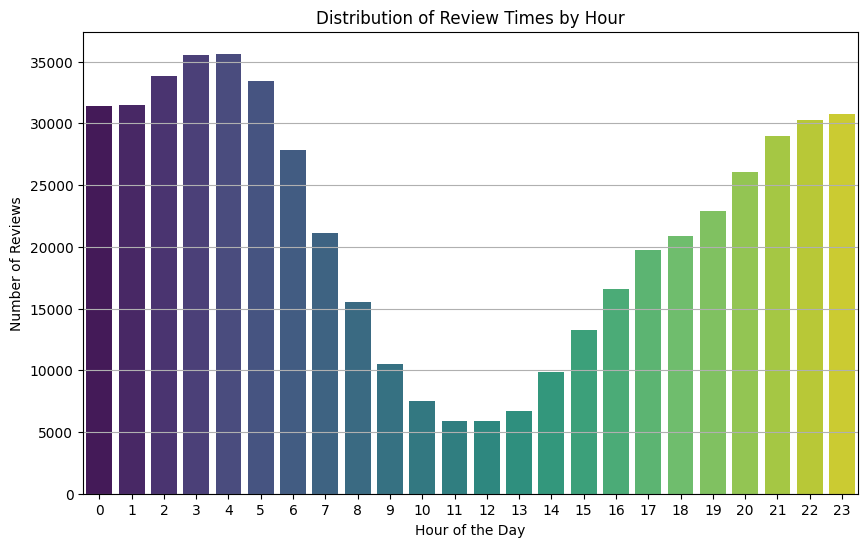

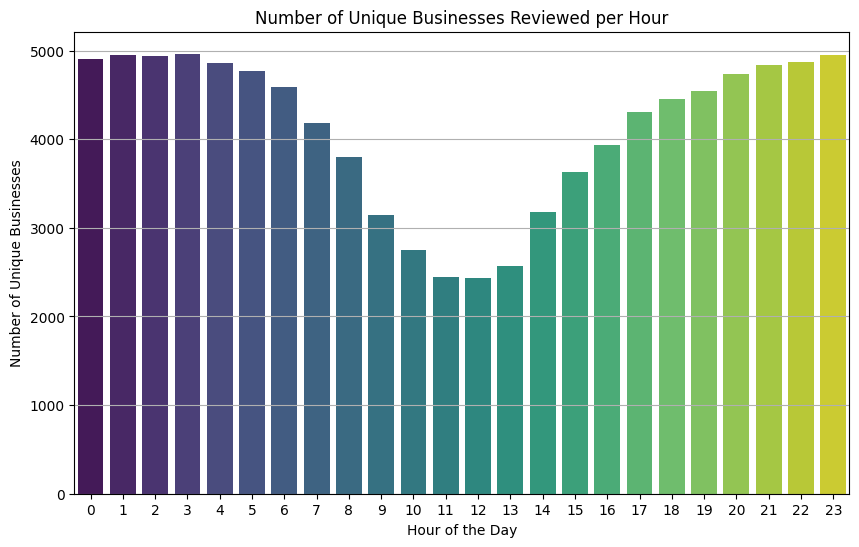

In [19]:
# Analyze the distribution of reviews by hour
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='review_time', palette='viridis')
plt.title('Distribution of Review Times by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Reviews')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

# Analyze the number of businesses reviewed at different times
unique_gmap_ids_per_hour = df.groupby('review_time')['gmap_id'].nunique().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=unique_gmap_ids_per_hour, x='review_time', y='gmap_id', palette='viridis')
plt.title('Number of Unique Businesses Reviewed per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Unique Businesses')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

### Insights from Visualizations

The visualizations above provide insights into the review patterns based on the time of day:

**Distribution of Review Times by Hour:**
- The first plot shows the total number of reviews submitted at each hour of the day.
- We can observe that there is a peak in reviews during certain hours, indicating when users are most active in leaving feedback. This could be related to business operating hours, user routines, or other factors.

**Number of Unique Businesses Reviewed per Hour:**
- The second plot shows the number of distinct businesses (identified by `gmap_id`) that received at least one review during each hour.
- This helps understand if reviews are spread across many businesses throughout the day or concentrated on a few during specific times.

Further analysis could involve looking at the average rating per hour, the types of businesses reviewed at different times, or correlating review times with other features in the dataset.

**Answer 1.3**

**Answer 1.3.1**

In [20]:
# rename the name column in the meta_data to avoid duplicate name error with the reviews data set
df_meta = df_meta.withColumnRenamed("name", "business_name")

# Join the two DataFrames on the 'gmap_id' column
joined_df = df_review.join(df_meta, on="gmap_id", how="inner")

#show total count of records in joined dataset
print(f"The total no. of records in joined dataset is: {joined_df.count()}")
# Show the schema and some rows of the joined DataFrame
print("Joined DataFrame Schema:")
joined_df.printSchema()

print("Joined DataFrame (Top 5):")
joined_df.show(5, truncate=False)

The total no. of records in joined dataset is: 521997
Joined DataFrame Schema:
root
 |-- gmap_id: string (nullable = true)
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = false)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- newtime: date (nullable = true)
 |-- business_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- num_of_reviews: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)

Joined DataFram

**Observations**

i) The total no of records in the reviews data set before joining was 521,515, the total no in the joined data frame is 521,997 pointing to possibly few duplicates in the joined dataset.

In [ ]:
# Extract the day of the week from the 'newtime' column
joined_df_with_day = joined_df.withColumn("day_of_week", date_format(col("newtime"), "E"))


#Count reviews per day
daily_counts = joined_df_with_day.groupBy("day_of_week").agg(
    count("*").alias("daily_review_count")
)

#Average review count across all Mondays, Tuesdays, etc.
avg_by_weekday = daily_counts.groupBy("day_of_week").agg(
    {"daily_review_count": "avg"}
).withColumnRenamed("avg(daily_review_count)", "avg_daily_reviews")


# Define the order of the days of the week for plotting
day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Convert to pandas DataFrame for plotting
reviews_by_day_pd = avg_by_weekday.toPandas()

# Sort the pandas DataFrame by the defined day order
reviews_by_day_pd['day_of_week'] = pd.Categorical(reviews_by_day_pd['day_of_week'], categories=day_order, ordered=True)
reviews_by_day_pd = reviews_by_day_pd.sort_values('day_of_week')


# Plot average number of daily reviews per weekday
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=reviews_by_day_pd,
    x='day_of_week',
    y='avg_daily_reviews',
    marker='o',
    linewidth=2,
    color='seagreen'
)
plt.title('Average Daily Review Submissions per Day of the Week', fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Average Reviews per Day')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Average number of reviews per day of the week:")
display(reviews_by_day_pd.reset_index(drop=True).round(2))



#### **Observations**
The above code extracts the day of the week from the joined dataset and groups this data by average daily review count. The spark data frame is then converted into a pandas data frame for plotting.

The day of the week that has the highest averaged submissions is Sunday while Friday has the lowest reviews. Overall, weekends (Saturday and Sunday have the highest reviews.)

**Answer 1.3.2**

In [ ]:
# Find the day with the maximum number of reviews
peak_day = reviews_by_day_pd.loc[reviews_by_day_pd['avg_daily_reviews'].idxmax()]['day_of_week']
print(f"The workday with the most reviews is: {peak_day}")

# Filter the joined DataFrame for the peak day
peak_day_df = joined_df_with_day.filter(col("day_of_week") == peak_day)

# Group by business name and category and calculate the average rating
avg_rating_by_business = peak_day_df.groupBy("business_name", "category").agg(avg("rating").alias("average_rating"))

# Find the business(es) with the highest average rating on the peak day
highest_rated_businesses = avg_rating_by_business.orderBy(col("average_rating").desc()).limit(5)

print(f"\nBusinesses with the highest average rating on {peak_day} (Top 5):")
highest_rated_businesses.show(truncate=False)

**Observations**

The workday with  the most reviews is sunday, while top 5 businesses and their categories are shown in the table output with an average rating of 5.

**Answer 1.3.3**

In [ ]:
# Group by category and count the number of businesses
category_counts = joined_df.groupBy("category").count()

# Order by count in descending order
category_counts = category_counts.orderBy(col("count").desc())

# Convert to pandas DataFrame
category_counts_pd = category_counts.toPandas()

# Select the top 10 categories
top_10_categories = category_counts_pd.head(10)

# Create a bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_categories, x='category', y='count', palette='viridis')
plt.title('Top 10 Business Categories by Count')
plt.xlabel('Business Category')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Get the list of top 10 categories
top_categories_list = top_10_categories['category'].tolist()

# Filter the joined DataFrame to include only the top 10 categories
filtered_df = joined_df_with_day.filter(col("category").isin(top_categories_list))

# Extract the hour of the day from the 'newtime' column
filtered_df = filtered_df.withColumn("review_hour", date_format(col("newtime"), "H"))

# Show the schema and some rows of the filtered DataFrame with the new column
print("Filtered DataFrame Schema:")
filtered_df.printSchema()

print("Filtered DataFrame (Top 5):")
filtered_df.show(5, truncate=False)

In [ ]:
# Group by category and review_hour and count the number of reviews
reviews_by_category_hour = filtered_df.groupBy("category", "review_hour").count()

# Find the peak review hour for each category

window_spec = Window.partitionBy("category").orderBy(col("count").desc())

ranked_reviews = reviews_by_category_hour.withColumn("rank", rank().over(window_spec))

peak_hours_per_category = ranked_reviews.filter(col("rank") == 1)

# Display the peak review hour for each of the top 10 categories
print("Peak review hour for each of the top 10 categories:")
peak_hours_per_category.orderBy(col("count").desc()).show(truncate=False)

## Analyze average ratings by category


In [ ]:
# Group by category and calculate the average rating
avg_rating_by_category = joined_df.groupBy("category").agg(avg("rating").alias("average_rating"))

# Order by average_rating in descending order
avg_rating_by_category = avg_rating_by_category.orderBy(col("average_rating").desc())

# Convert to pandas DataFrame
avg_rating_by_category_pd = avg_rating_by_category.toPandas()

# Select the top 10 categories by average rating
top_10_avg_rating_categories = avg_rating_by_category_pd.head(10)

# Create a bar plot
plt.figure(figsize=(20, 15))
sns.barplot(data=top_10_avg_rating_categories, x='category', y='average_rating', palette='viridis')
plt.title('Top 10 Business Categories by Average Rating')
plt.xlabel('Business Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis Summary:**

Business Categories, Peak Hours, and Average Ratings
This analysis explored review patterns based on business categories, focusing on the distribution of businesses, peak review hours for top categories, and average ratings across categories.

**Distribution of Businesses Across Categories:**

Based on the analysis of business categories, the most frequent categories in the dataset are:

['Shopping mall']
['Fast food restaurant', 'Breakfast restaurant', 'Hamburger restaurant', 'Restaurant', 'Sandwich shop']
['Department store', 'Clothing store', 'Craft store', 'Shoe store', 'Sporting goods store']
['Grocery store', 'Grocery delivery service']
['Mexican restaurant']
['Fast food restaurant', 'Breakfast restaurant', 'Burger joint', 'Restaurant', 'Sandwich shop']
['Restaurant']
['Warehouse store', 'Department store']
['American restaurant']
['Gas station']
The bar plot titled "Top 10 Business Categories by Count" visually represents this distribution, clearly showing the categories with the highest number of associated businesses.

**Peak Review Hours for Top Categories:**

The analysis of peak review hours for the top 10 business categories revealed that for all of these categories, the hour with the highest number of reviews is '0' (which likely corresponds to midnight or the beginning of the day, depending on the exact time data representation).

**Average Ratings by Category:**

The calculation of average ratings by category identified the categories with the highest average ratings. The top 10 categories by average rating are:

['Beauty salon', 'Hair care', 'Hair salon', 'Nail salon']
['Snowboard shop', 'Clothing store', 'Shoe store', 'Ski shop', 'Sporting goods store', 'Store']
['Horseback riding service', 'Bed & breakfast', 'Cabin rental agency', 'Cottage', 'Guest house']
['Pediatric dentist', 'Dentist']
['Pediatrician']
['Surgeon', 'Doctor', 'Medical spa']
['Waterfall', 'Tourist attraction']
['Rafting', 'Raft trip outfitter', 'Scenic spot']
['Dogsled ride service', 'Helicopter tour agency', 'Tour operator']
['Leather goods store', 'Store']
The bar plot titled "Top 10 Business Categories by Average Rating" illustrates these top-rated categories and their corresponding average ratings.



**Answer 1.4**

In [ ]:
# Combine all review text into a single string in PySpark
all_reviews_text_df = joined_df.select(concat_ws(" ", col("text"))).collect()
all_reviews_text = all_reviews_text_df[0][0] if all_reviews_text_df else ""


# Remove punctuation and convert to lowercase using PySpark functions
words_df = joined_df.select(lower(regexp_replace(col("text"), r'[^\w\s]', '')).alias("text"))
words_df = words_df.select(explode(split(col("text"), "\s+")).alias("word"))

# Remove common English stop words using PySpark
stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "herself",
    "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what",
    "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
    "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did",
    "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "no", "review"
])

words_df = words_df.filter(~col("word").isin(stop_words)).filter(length(col("word")) > 1)


# Count the frequency of each word using PySpark
word_counts_df = words_df.groupBy("word").count().orderBy(col("count").desc())

# Get the top 30 most common words
top_30_words = word_counts_df.limit(30).collect()

print("Top 30 most common words:")
for row in top_30_words:
    print(f"{row['word']}: {row['count']}")

# Generate word clouds for each year
# Extract the year from the 'newtime' column
reviews_with_year = joined_df.withColumn("review_year", year(col("newtime")))

# Group by year and concatenate text for each year
reviews_by_year_df = reviews_with_year.groupBy("review_year").agg(concat_ws(" ", collect_list(col("text"))).alias("all_text"))

# Collect the data for word cloud generation
reviews_by_year_pd = reviews_by_year_df.toPandas()

In [ ]:
#sort reviews by year before plotting the word clouds
reviews_by_year_pd.sort_values(by='review_year', inplace=True)
reviews_by_year_pd.head()

In [ ]:
# Generate word cloud for each year
num_years = len(reviews_by_year_pd)
num_cols = 2
# Calculate number of rows needed
num_rows = (num_years + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 5 * num_rows))
# Flatten the array of axes for easy iteration

axes = axes.flatten()
for i, (index, row) in enumerate(reviews_by_year_pd.iterrows()):
    review_year_val = row['review_year']
    text = row['all_text']

    if text: # Check if there is any text for the year
        # Remove punctuation and convert to lowercase
        text = re.sub(r'[^\w\s]', '', text).lower()
        words = text.split()
        words = [word for word in words if word not in stop_words and len(word) > 1]
        text = " ".join(words)

        if text: # Check if there are any words left after removing stop words
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].axis('off')
            axes[i].set_title(f'Word Cloud for {review_year_val}')
        else:
            axes[i].axis('off') # Hide axis if no words to display
            axes[i].set_title(f'No significant words for {review_year_val}')
    else:
        axes[i].axis('off') # Hide axis if no text for the year
        axes[i].set_title(f'No reviews for {review_year_val}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Insights from Top Words by Year

Analyzing the top words for each year provides a clearer view of the review content and highlights shifts in focus over time:

*   **Consistency of Core Themes:** Words like "great," "good," "food," "place," and "service" consistently appear in the top words across many years, indicating that these are fundamental aspects of the reviewed businesses that users frequently comment on.
*   **Growth in Review Volume:** The increasing counts for the top words over the years (especially noticeable from 2016 onwards) directly reflect the significant growth in the number of reviews in the dataset during this period.
*   **Dominance of Positive Language:** The prevalence of positive words like "great," "good," and "amazing" in the top lists suggests a generally positive sentiment within the reviews, based on the most frequent terms.
*   **Specific Mentions:** While the very top words are quite general, looking beyond the top 5 or 10 for each year might reveal more specific keywords related to particular types of businesses or events that were prominent in those years.


**Answer 1.5**

In [ ]:
# Determine the number of unique reviewers per business
unique_reviewers_per_business = joined_df.groupBy("business_name", "gmap_id").agg(countDistinct("user_id").alias("unique_reviewer_count"))

print("Number of unique reviewers per business (Top 10):")
unique_reviewers_per_business.orderBy(col("unique_reviewer_count").desc()).show(10, truncate=False)

# Determine the number of unique reviewers per category
unique_reviewers_per_category = joined_df.groupBy("category").agg(countDistinct("user_id").alias("unique_reviewer_count"))

print("Number of unique reviewers per category (Top 10):")
unique_reviewers_per_category.orderBy(col("unique_reviewer_count").desc()).show(10, truncate=False)

# Analyze temporal patterns of reviews by year
reviews_by_year = joined_df.withColumn("review_year", year(col("newtime"))).groupBy("review_year").count().orderBy("review_year")

print("Number of reviews per year:")
reviews_by_year.show(truncate=False)

# Analyze temporal patterns of reviews by month
reviews_by_month = joined_df.withColumn("review_month", month(col("newtime"))).groupBy("review_month").count().orderBy("review_month")

print("Number of reviews per month:")
reviews_by_month.show(truncate=False)

# Analyze temporal patterns of reviews by day of the week
reviews_by_dayofweek = joined_df.withColumn("review_dayofweek", dayofweek(col("newtime"))).groupBy("review_dayofweek").count().orderBy("review_dayofweek")

print("Number of reviews per day of the week (1 = Sunday, 7 = Saturday):")
reviews_by_dayofweek.show(truncate=False)

### Insights from Unique Reviewers and Temporal Patterns

**Unique Reviewers per Business and Category:**

*   The analysis of unique reviewers per business reveals the businesses that have attracted the largest number of distinct individuals to leave reviews. The top businesses with the highest unique reviewer counts are:
    *   Moose's Tooth Pub & Pizzeria
    *   Dimond Center
    *   Walmart Supercenter (multiple locations appear in the top 10)
    *   Costco Wholesale (multiple locations appear in the top 10)
    *   Anchorage 5th Avenue Mall
    *   49th State Brewing - Anchorage
    *   Tikahtnu Commons

*   Similarly, examining unique reviewers per category highlights the business categories that receive reviews from the broadest range of users. The top categories by unique reviewer count are:
    *   ['Shopping mall']
    *   ['Department store', 'Clothing store', 'Craft store', 'Discount store', 'Electronics store', 'Grocery store', 'Home goods store', 'Sporting goods store', 'Supermarket', 'Toy store']
    *   ['Fast food restaurant', 'Breakfast restaurant', 'Coffee shop', 'Hamburger restaurant', 'Restaurant', 'Sandwich shop']
    *   ['Grocery store', 'Grocery delivery service']
    *   ['Mexican restaurant']
    *   ['Warehouse store', 'Department store']
    *   ['Fast food restaurant', 'Breakfast restaurant', 'Burrito restaurant', 'Lunch restaurant', 'Takeout Restaurant', 'Mexican restaurant', 'Restaurant', 'Taco restaurant', 'Tex-Mex restaurant', 'Vegetarian restaurant']
    *   ['Restaurant']
    *   ['American restaurant']
    *   ['Grocery store', 'Propane supplier']

These findings indicate that large retail centers, popular restaurants (especially fast food and casual dining), and general merchandise stores tend to attract reviews from a wider customer base.

**Seasonal Patterns of Reviews:**

*   **Reviews by Year:** The number of reviews has significantly increased over the years, with a substantial jump starting around 2016 and peaking in 2019 and 2020. This suggests a growing trend of users leaving reviews or an expansion of the dataset's coverage in recent years.

* **Reviews by Month:** The months June to September have the highest review counts > 45k. This shows that most customers tend to spend more time during summer months shopping at large retail centers, restuarants and general merchandise shops. It might also be reflective customer behavioral patterns during different times of the year.

* **Reviews by day of week** The days (saturday and sunday) have more review counts > 75k, compared to the rest of the days an indicator that customers tend to spend more times shopping during the weekend that over the rest of the days.


**Answer 1.6**

**Answer 1.6.1**

A common approach for building a recommendation system for businesses based on customer reviews is using Collaborative Filtering . This method relies on the idea that users who liked similar items in the past will like similar items in the future (*Su,X,Khoshgoftaar, T. M 2009*).

Our strategy is to use the Alternating Least squares approach (ALS). This is a matrix factorization method which alternately solves for user and item feature matrices to minimize rating prediction error *(Zhou et al., 2008; Tan, Steinbach and Kumar, 2019)*. It is widely used in large-scale collaborative filtering systems due to its scalability and parallelization capabilities *(Zhou et al., 2008)*.

The algorithm alternates between fixing one matrix and solving for the other using least squares regression, iteratively minimizing the prediction error until convergence.

ALS is especially suited for large-scale, sparse datasets and is efficiently implemented in distributed computing frameworks like Apache Spark’ `MLib`.

**a.	Create User-Item Matrix:**

This involves creating a matrix where rows represent users, columns represent businesses, and the values are the ratings given by the user to the business.

**b.	Model iniatialization:**
Model initialization in ALS refers to how the latent user and item feature matrices are initially set before the optimization process begins.
The ALS aims to find matrices U (user features) and V(item features in this case the businesses) such that: R≈U×VTranspose.

(where
R is the user–item rating matrix), the algorithm needs starting values for
𝑈
U and
𝑉
V.
 Spark MLlib internally distributes the computation across the cluster (or your local CPU cores).
It iteratively updates the user and item matrices to minimize prediction error (regularized least squares).

**c.	Model training:**
This involves splitting the data into training and testing sets. The model predicts ratings for (user, business) pairs in the test set. To measure how close the predicted ratings are to the actual ratings RMSE (Root Mean Sqaured Error) is used. The lower the RMSE, the better the accuracy.

**d.	Generate Recommendations**:

To generate the recommendations the to N businesses each user is most likely to rate based on their latent vector similarity is used. This is achieved by the dot products between users and business latent vectors. The higher the score, the stronger is the recommendation.



**Answer 1.6.2**

In [ ]:
# Create a user-item matrix using the relevant columns from the joined DataFrame
# Select and cast the necessary columns
ratings_df = joined_df.select(
    col("user_id").cast(IntegerType()).alias("userId"),
    col("gmap_id").alias("itemId"),
    col("rating").cast(DoubleType()).alias("rating")
)

# Drop rows with null values in the selected columns
ratings_df = ratings_df.dropna(subset=["userId", "itemId", "rating"])

# Convert item IDs to numerical IDs for ALS
# Hash the string IDs
ratings_df = ratings_df.withColumn("itemIdNumeric", hash(col("itemId")))

# Split the data into training and testing sets
(training, test) = ratings_df.randomSplit([0.8, 0.2], seed=123)

# Build the recommendation model using ALS (Alternating Least Squares)
als = ALS(maxIter=5, regParam=0.09, rank=20, userCol="userId", itemCol="itemIdNumeric", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# Generate top 10 business recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Show the recommendations for a few users
print("Top 10 recommendations for users:")
userRecs.show(5, truncate=False)

# Generate top 10 user recommendations for each business
itemRecs = model.recommendForAllItems(10)

# Show the recommendations for a few businesses
print("Top 10 user recommendations for businesses:")
itemRecs.show(5, truncate=False)



**Comments**




**Answer 1.7**

**Answer 1.7.1**

In [ ]:
# Group by category and calculate the average rating
avg_rating_by_category = joined_df.groupBy("category").agg(avg("rating").alias("average_rating"))

# Order by average_rating in descending order
avg_rating_by_category = avg_rating_by_category.orderBy(col("average_rating").desc())

# Convert to pandas DataFrame for plotting
avg_rating_by_category_pd = avg_rating_by_category.toPandas()

# Select the top 20 categories by average rating for better visualization
top_20_avg_rating_categories = avg_rating_by_category_pd.head(20)

# Create a bar plot
plt.figure(figsize=(20, 15))
sns.barplot(data=top_20_avg_rating_categories, x='category', y='average_rating', palette='viridis')
plt.title('Top 20 Business Categories by Average Rating')
plt.xlabel('Business Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Explore the categories with the lowest average ratings
bottom_20_avg_rating_categories = avg_rating_by_category_pd.tail(20)

plt.figure(figsize=(20, 10))
sns.barplot(data=bottom_20_avg_rating_categories, x='category', y='average_rating', palette='viridis')
plt.title('Bottom 20 Business Categories by Average Rating')
plt.xlabel('Business Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

### Insights from Relationship between Rating and Business Categories

The visualizations above illustrate the relationship between business categories and their average ratings.

**Top 20 Business Categories by Average Rating:**

The first bar plot displays the top 20 business categories with the highest average ratings. Observing this plot, we can identify categories that consistently receive positive reviews from users. These might include niche services, specialized shops, or attractions that cater to specific interests and potentially exceed customer expectations within those areas. It's worth noting that some categories might have a smaller number of reviews contributing to their high average, which could make the average less representative.

**Bottom 20 Business Categories by Average Rating:**

The second bar plot shows the bottom 20 business categories with the lowest average ratings. This plot helps pinpoint categories that tend to receive lower ratings. These could be types of businesses that are more prone to customer complaints, have inherent challenges in meeting expectations, or face strong competition leading to critical reviews. Understanding these categories can be valuable for businesses within them to identify areas for improvement.

**General Observations:**

*   The plots reveal a variation in average ratings across different business categories.
*   Some categories seem to consistently perform better in terms of customer satisfaction (based on average rating) than others.
*   To gain deeper insights, it would be beneficial to also consider the number of reviews for each category when interpreting the average ratings, as categories with very few reviews might have skewed averages.
*   Further analysis could involve examining the distribution of ratings within specific categories or exploring the common themes in the reviews for high- and low-rated categories.

**Answer 1.7.2**

In [ ]:
# Define a threshold for low ratings (e.g., ratings less than or equal to 2)
low_rating_threshold = 2

# Filter the joined DataFrame to get reviews with low ratings
low_rated_reviews = joined_df.filter(col("rating") <= low_rating_threshold)

# Count the number of low-rated reviews
num_low_rated_reviews = low_rated_reviews.count()

print(f"Number of reviews with a rating of {low_rating_threshold} or less: {num_low_rated_reviews}")

# Extract the text from the low-rated reviews and combine it into a single string
low_rated_text_df = low_rated_reviews.select(concat_ws(" ", col("text"))).collect()
low_rated_text = low_rated_text_df[0][0] if low_rated_text_df else ""

# Process the text: remove punctuation, convert to lowercase, and split into words
if low_rated_text:
    low_rated_words = low_rated_reviews.select(lower(regexp_replace(col("text"), r'[^\w\s]', '')).alias("text"))
    low_rated_words = low_rated_words.select(explode(split(col("text"), "\s+")).alias("word"))

    # Remove common English stop words and words with length less than or equal to 1
    stop_words_extended = stop_words.union({"no", "review"}) # Add "no" and "review" to stop words
    low_rated_words = low_rated_words.filter(~col("word").isin(stop_words_extended)).filter(length(col("word")) > 1)

    # Count the frequency of each word
    low_rated_word_counts_df = low_rated_words.groupBy("word").count().orderBy(col("count").desc())

    # Get the top 30 most common words in low-rated reviews
    top_30_low_rated_words = low_rated_word_counts_df.limit(30).collect()

    print("\nTop 30 most common words in low-rated reviews:")
    for row in top_30_low_rated_words:
        print(f"{row['word']}: {row['count']}")
else:
    print("\nNo low-rated reviews found to analyze text.")

### **Analysis of Low-Rated Reviews**

Based on the analysis of reviews with a rating of 2 or less:

- There are **36884** reviews with a low rating.
- The most common words appearing in these low-rated reviews include:


**food**: This suggests a product indicating poor food quality or service

**service**: This may relate to the quality of service, mostly poor services offered.

**get**: This could relate to difficulty in receiving service or products

**time**: This suggests that issues related to waiting times or the duration of service might be a common complaint.

**like**: Can be used in various contexts, but in negative reviews, it might express disappointment or unfavorable comparisons.

**bad**: A direct expression of dissatisfaction.

**never**: Used to emphasize a consistently negative experience.

**store**: Many low ratings are for retail establishments.

**went**: Describes negative experiences encountered during a visit.

**dont**: Indicates negative experiences or lack of something expected.

These words collectively suggest that common reasons for low ratings include issues with service speed and efficiency, poor customer service and communication, problems with products or work quality, and negative experiences related to specific types of businesses like restaurants and retail stores.

**Answer 1.8**

**Answer 1.8.1**

In [ ]:
# Sort reviews for each business by newtime
window_spec_business = Window.partitionBy("gmap_id").orderBy(asc("newtime"))
sorted_reviews_by_business = joined_df.withColumn("row_number", rank().over(window_spec_business)).drop("row_number")

# Group by user_id and collect the list of business names
user_business_list_df = sorted_reviews_by_business.groupBy("user_id").agg(collect_list("business_name").alias("business_list"))

# Convert the result to a list of (user_id, business_list) tuples (optional, for display)
user_business_list = user_business_list_df.collect()

# Display the result for a few users
print("Business list for each user (first 10 users):")
for row in user_business_list[:10]:
    print(f"User ID: {row['user_id']}, Businesses: {row['business_list']}")

**Answer 1.8.2**

In [ ]:
# Function to check for repeated business names in a list
def has_repeated_businesses(business_list):
    if not business_list:
        return False
    # Convert the list to a set to find unique businesses
    unique_businesses = set(business_list)
    # If the number of unique businesses is less than the total number of reviews,
    # it means there are repeated business names
    return len(unique_businesses) < len(business_list)

# Count the number of users with repeated business names in their list
users_with_repeated_businesses_count = sum(
    1 for user_id, business_list in user_business_list if has_repeated_businesses(business_list)
)

print(f"Number of users with repeated business names in their review history: {users_with_repeated_businesses_count}")

In [ ]:
# Identify and print duplicated business names and their counts for each reviewer
print("\nDuplicated business names and their counts for each user:")
count = 0
for user_id, business_list in user_business_list:
    if has_repeated_businesses(business_list):
        # Use Counter to find duplicated business names and their counts
        business_counts = Counter(business_list)
        duplicated_businesses = {business: count for business, count in business_counts.items() if count > 1}
        if duplicated_businesses:
            print(f"User ID: {user_id}")
            count += 1
            for business, business_count in duplicated_businesses.items():
                if count <= 1000:  # Limit to the first 1000 lines
                    print(f"  - {business}: {business_count} times")
                    count += 1
                else:
                    break # Exit the inner loop if 1000 lines are reached
    if count > 1000: # Exit the outer loop if 1000 lines are reached
        break

In [ ]:
# Create a new list to store user_id and a list of unique businesses
user_business_list_unique = []

# Iterate through the original list
for user_id, business_list in user_business_list:
    # Convert the business list to a set to get unique businesses, then convert back to a list
    unique_businesses = list(set(business_list))
    # Append the user_id and the list of unique businesses to the new list
    user_business_list_unique.append((user_id, unique_businesses))

# Display the result for a few users to verify
print("Business list for each user with duplicates removed (first 10 users):")
for row in user_business_list_unique[:10]:
    print(f"User ID: {row[0]}, Businesses: {row[1]}")

**Answer 1.8.3**

In [ ]:
# Apply the hash function directly to each element in the business_list column
encoded_user_business_list_df = user_business_list_df.withColumn(
    "encoded_business_list",
    # Use transform to apply the hash function to each element in the list
    expr("transform(business_list, business -> hash(business))")
)

# Display the result for a few users to verify
print("Business list for each user with encoded business names (first 10 users):")
for row in encoded_user_business_list_df.collect()[:10]:
    print(f"User ID: {row['user_id']}, Encoded Businesses: {row['encoded_business_list']}")

In [ ]:
# Group the DataFrame by user_id and collect the unique gmap_id's into a set for fast lookups
encoded_user_business_list_series = df.groupby('user_id')['gmap_id'].apply(lambda x: set(x.unique()))

# Convert the Series back to a DataFrame with a descriptive column name
encoded_user_business_list_df = encoded_user_business_list_series.rename('reviewed_businesses').to_frame()

print("--- Encoded User-Business List (Sample) ---")
display(encoded_user_business_list_df.head())

In [ ]:
#  created a sample user-item data set for memory efficiency to avoid running out of RAM
user_sets = encoded_user_business_list_series  #get user sets

sample_size = min(10000, len(user_sets))  # limit sample size to 10000
user_sets_sample = user_sets.sample(n=sample_size, random_state=42)

print(f"Using {sample_size} users for similarity computation (sampled).")


# Create sparse user-item matrix

unique_items = sorted({item for items in user_sets_sample for item in items})
item_index = {item: i for i, item in enumerate(unique_items)}

rows, cols = [], []
for row_idx, items in enumerate(user_sets_sample):
    cols.extend([item_index[i] for i in items])
    rows.extend([row_idx] * len(items))

data = np.ones(len(rows), dtype=np.float32)
user_item_matrix = csr_matrix(
    (data, (rows, cols)), shape=(len(user_sets_sample), len(unique_items))
)


# Compute cosine similarity
cosine_sim_matrix = cosine_similarity(user_item_matrix, dense_output=False)


# Extract Top-N similar users for each user
top_N = 10
user_ids = user_sets_sample.index.to_list()
similar_users = []

# Iterate over each user row in sparse similarity matrix
for i, row in enumerate(cosine_sim_matrix):
    # Convert sparse row → (user indices, similarity values)
    row_coo = row.tocoo()
    sim_scores = list(zip(row_coo.col, row_coo.data))

    # Remove self-similarity
    sim_scores = [(j, sim) for j, sim in sim_scores if j != i]

    # Sort by similarity and select top N
    top_neighbors = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_N]

    # Map back to user IDs
    user_i = user_ids[i]
    for j, sim in top_neighbors:
        similar_users.append({"user_a": user_i, "user_b": user_ids[j], "similarity": sim})

# Convert to DataFrame
topN_df = pd.DataFrame(similar_users)


# Display sample results

print(f"\nTop {top_N} similar users per user (sample):")
display(topN_df.head(20))
print(f"\nGenerated {len(topN_df):,} user–user similarity pairs across {len(user_ids)} users.")


Cosine similarity measures how similar two vectors are by comparing the angle between them, not their magnitude.

Formally, for two users A and B represented as vectors of their item interactions:

cosine_similarity
(
𝐴
,
𝐵
)
=
𝐴
⋅
𝐵
∥
𝐴
∥
×
∥
𝐵
∥
cosine_similarity(A,B)=
∥A∥×∥B∥
A⋅B
	​


𝐴
⋅
𝐵
A⋅B → dot product (sum of element-wise products)

∥
𝐴
∥
∥A∥ and
∥
𝐵
∥
∥B∥ → vector magnitudes (lengths)

The result ranges between 0 (completely dissimilar) and 1 (identical direction).

**Answer 2**

**Answer 2.1**

In [ ]:
# convert newtime column into a date only column

joined_df = joined_df.withColumn("newtime_date", to_date(col("newtime")))

# aggregate total reviews per day (count rows per day)
daily_counts_spark = joined_df.groupBy("newtime_date").count().withColumnRenamed("count", "review_count")

# inspect a few rows on the new time date column
display(daily_counts_spark.orderBy("newtime_date").limit(10))


# convert the spark data frame into a pandas df
daily_counts_pd = daily_counts_spark.toPandas()

# Ensure the column names the right types
daily_counts_pd.rename(columns={"newtime_date": "review_time"}, inplace=True)
daily_counts_pd["review_time"] = pd.to_datetime(daily_counts_pd["review_time"]).dt.normalize()
daily_counts_pd = daily_counts_pd.sort_values("review_time").reset_index(drop=True)


#create a continuous daily time series and impute missing days with the mean
# Create full date range from min to max
min_date = daily_counts_pd["review_time"].min()
max_date = daily_counts_pd["review_time"].max()
full_range = pd.date_range(start=min_date, end=max_date, freq="D")

# Reindex to full range and compute mean for imputation
daily_series = daily_counts_pd.set_index("review_time")["review_count"].reindex(full_range)

# Compute mean reviews per day using the whole original counts
# compute mean = total reviews / total calendar days in the full range.
total_reviews = daily_counts_pd["review_count"].sum()
total_days = len(full_range)
mean_reviews_imputation = total_reviews / total_days

# Fill missing days with the mean value
imputed_ts = daily_series.fillna(mean_reviews_imputation)
imputed_ts.index.name = "review_time"
imputed_ts.name = "review_count"
imputed_ts = imputed_ts.astype(float)

 # flag frequency for decomposition
imputed_ts.index.freq = "D"

print("--- Imputation summary ---")
print(f"Min date: {min_date}, Max date: {max_date}, Total days: {total_days}")
print(f"Total reviews (original aggregated): {total_reviews}")
print(f"Imputation value (mean reviews/day): {mean_reviews_imputation:.4f}")
print(f"Original observed days: {len(daily_counts_pd)}, Missing days filled: {total_days - len(daily_counts_pd)}")

#Seasonal decomposition - additive
# weekly seasonality
period = 7
min_required = 2 * period

if len(imputed_ts) >= min_required:
    decomposition = seasonal_decompose(imputed_ts, model="additive", period=period)
    decomposed_used_series = imputed_ts  # store for plotting below
    used_freq = "D"
    used_period = period
    print(f"Performing additive decomposition with period={period} on {len(imputed_ts)} daily points.")
else:
    #aggregate to weekly sums and try decomposition on weeks
    print(f"Not enough daily observations ({len(imputed_ts)}). Aggregating to weekly and attempting decomposition.")
    weekly = imputed_ts.resample("W").sum()
    fallback_period = 4  # 4 weeks ~ monthly seasonality
    if len(weekly) >= 2 * fallback_period:
        decomposition = seasonal_decompose(weekly, model="additive", period=fallback_period)
        decomposed_used_series = weekly
        used_freq = "W"
        used_period = fallback_period
        print(f"Performing additive decomposition with period={fallback_period} on {len(weekly)} weekly points.")
    else:
        # If still too short, we will not decompose, but will still show the (aggregated) series
        decomposition = None
        decomposed_used_series = weekly if "weekly" in locals() else imputed_ts
        used_freq = "W" if "weekly" in locals() else "D"
        used_period = fallback_period if "weekly" in locals() else None
        print("Still not enough points for decomposition. Will show trend-only chart and descriptive stats.")

# Plot decomposition or fallback charts
if decomposition is not None:
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    decomposition.observed.plot(ax=axes[0], title="Observed (imputed) review counts")
    axes[0].set_ylabel("count")
    decomposition.trend.plot(ax=axes[1], title="Trend")
    axes[1].set_ylabel("count")
    decomposition.seasonal.plot(ax=axes[2], title=f"Seasonal (period={used_period})")
    axes[2].set_ylabel("count")
    decomposition.resid.plot(ax=axes[3], title="Residuals")
    axes[3].set_ylabel("count")
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(12,4))
    decomposed_used_series.plot(title="Review counts (fallback aggregation) — trend-only")
    plt.xlabel("Time")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# perform Quick quantitative seasonality check
def seasonal_strength(decomp):
    """
    Compute a simple seasonal strength metric:
    S = max(0, 1 - Var(resid) / Var(trend + resid))
    """
    resid = decomp.resid.dropna()
    trend = decomp.trend.dropna()
    # align lengths
    common_index = resid.index.intersection(trend.index)
    if len(common_index) < 2:
        return np.nan
    resid_var = np.var(resid.loc[common_index])
    tr_plus_res_var = np.var((trend + resid).loc[common_index])
    if tr_plus_res_var == 0:
        return np.nan
    return max(0.0, 1.0 - resid_var / tr_plus_res_var)

if decomposition is not None:
    s_strength = seasonal_strength(decomposition)
    print(f"Seasonal strength (0-1 heuristic): {s_strength:.3f}")
    # Print seasonal summary: peak day-of-week if daily decomposition
    seasonal = decomposition.seasonal
    if used_freq == "D" and used_period == 7:
        # find day-of-week effect: map index to weekday name, aggregate by weekday
        seasonal_df = seasonal.reset_index()
        seasonal_df.columns = ["review_time", "seasonal"]
        seasonal_df["weekday"] = seasonal_df["review_time"].dt.day_name()
        weekday_avg = seasonal_df.groupby("weekday")["seasonal"].mean().reindex(
            ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
        )
        print("\nWeekly seasonal component average by weekday (higher -> positive seasonal uplift):")
        print(weekday_avg.round(3))
    else:
        print("Seasonal component summary (first 10 values):")
        print(seasonal.head(10).round(3))
else:
    print("Decomposition not available; no seasonal strength computed.")

**Answer 2.2**

In [ ]:
# ARIMA grid search for best (p,d,q) based on MAE

n_total = len(imputed_ts)
if n_total < 10:
    print(f"Warning: only {n_total} observations available. ARIMA models might be unreliable still attempt grid search.")

# Time-based train/test split (80% train, 20% test) — use last 20% as test
test_frac = 0.2
n_test = max(1, int(round(n_total * test_frac)))
n_train = n_total - n_test

train_ts = imputed_ts.iloc[:n_train]
test_ts  = imputed_ts.iloc[n_train:]

print(f"Total points: {n_total}, Train: {len(train_ts)}, Test: {len(test_ts)}")

# Parameter ranges
p_vals = [0, 1, 2]
d_vals = [0, 1, 2]
q_vals = [0, 1, 2]

results = []
best_mae = np.inf
best_cfg = None
best_model = None
best_forecast = None

# Grid search
for p in p_vals:
    for d in d_vals:
        for q in q_vals:
            order = (p, d, q)
            try:
                # fit ARIMA on train set
                model = ARIMA(train_ts, order=order)
                fitted = model.fit(method_kwargs={"warn_convergence": False})

                # forecast horizon equals length of test set
                fc = fitted.get_forecast(steps=len(test_ts))
                y_pred = fc.predicted_mean
                y_true = test_ts

                # Align index lengths (sometimes index types need conversion)
                y_pred.index = y_true.index

                mae = mean_absolute_error(y_true, y_pred)
                aic = getattr(fitted, 'aic', np.nan)
                bic = getattr(fitted, 'bic', np.nan)

                results.append({
                    "p": p, "d": d, "q": q,
                    "order": order,
                    "mae": mae,
                    "aic": aic,
                    "bic": bic
                })

                print(f"Tested ARIMA{order} -> MAE={mae:.4f}, AIC={aic:.1f}")

                if mae < best_mae:
                    best_mae = mae
                    best_cfg = order
                    best_model = fitted
                    best_forecast = y_pred.copy()
            except Exception as e:
                # model failed to converge or other numerical issue; record NaN
                print(f"ARIMA{order} failed: {e}")
                results.append({
                    "p": p, "d": d, "q": q,
                    "order": order,
                    "mae": np.nan,
                    "aic": np.nan,
                    "bic": np.nan,
                    "error": str(e)
                })

# results -> DataFrame
results_df = pd.DataFrame(results).sort_values("mae", na_position="last")
print("\n--- Grid search complete ---")
print(results_df[["order", "mae", "aic", "bic"]].head(10))

if best_cfg is None:
    raise RuntimeError("No successful ARIMA models were fit. Check data length and stationarity.")

print(f"\nBest ARIMA order by MAE: {best_cfg} with MAE = {best_mae:.4f}")

# Plot predictions of the best model vs test
plt.figure(figsize=(12,5))
plt.plot(train_ts.index, train_ts.values, label="Train", lw=1.5)
plt.plot(test_ts.index, test_ts.values, label="Test (actual)", lw=2)
plt.plot(best_forecast.index, best_forecast.values, label=f"ARIMA{best_cfg} forecast", lw=2)
plt.title(f"Best ARIMA{best_cfg} forecast vs actual — MAE={best_mae:.4f}")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Review count")
plt.tight_layout()
plt.show()

# re-fit best model on full data and forecast future horizon (e.g., 30 days)
full_model = ARIMA(imputed_ts, order=best_cfg).fit(method_kwargs={"warn_convergence": False})
horizon = 30  # forecast next 30 days
fc_full = full_model.get_forecast(steps=horizon)
fc_index = pd.date_range(imputed_ts.index[-1] + pd.Timedelta(days=1), periods=horizon, freq=imputed_ts.index.freq or 'D')
fc_mean = pd.Series(fc_full.predicted_mean.values, index=fc_index)

plt.figure(figsize=(12,5))
plt.plot(imputed_ts.index, imputed_ts.values, label="Observed (full series)")
plt.plot(fc_mean.index, fc_mean.values, label=f"Forecast next {horizon} days (ARIMA{best_cfg})")
plt.title("Forecast on full series")
plt.legend()
plt.tight_layout()
plt.show()

# Save results table for the report
results_df.to_csv("arima_gridsearch_results.csv", index=False)
print("Saved grid search results to arima_gridsearch_results.csv")


**Answer 2.3**

In [ ]:
#function to download pdf file from github
def download_github_pdf(raw_url, local_filename):
    """
    Downloads a file from a public GitHub 'raw' URL.

    Args:
        raw_url (str): The 'raw.githubusercontent.com' URL of the file.
        local_filename (str): The name to save the file as locally.
    """
    try:
        # Fetch the content from the raw URL
        print(f"Attempting to download file from: {raw_url}")

        # Use stream=True to handle potentially large files
        response = requests.get(raw_url, stream=True)

        # Raise an exception for bad status codes (4xx or 5xx)
        response.raise_for_status()

        # Save the content to the local file
        with open(local_filename, 'wb') as file:
            # Iterate over the response content in chunks
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"\n Successfully downloaded and saved to: {os.path.abspath(local_filename)}")
        print(f"File size: {os.path.getsize(local_filename) / (1024*1024):.2f} MB")

    except requests.exceptions.HTTPError as e:
        print(f"\n Error downloading file: HTTP Error {response.status_code}")
        print(f"Details: {e}")
        print("Note: This often means the file or repository is private, or the URL is incorrect.")
    except requests.exceptions.RequestException as e:
        print(f"\n An error occurred during the request: {e}")
    except Exception as e:
        print(f"\n An unexpected error occurred: {e}")


# Use the RAW URL for downloading file contents
raw_file = "https://raw.githubusercontent.com/dnmuturi/SIT742/main/UA_Indigenous_Strategy_Annual_Report_May-2022.pdf"

# retain the same name of the downloaded file
downloaded_file = "UA_Indigenous_Strategy_Annual_Report_May-2022.pdf"

# Execute the function to download the pdf file
download_github_pdf(raw_file, downloaded_file)

In [ ]:
!pip install pdfplumber

In [ ]:
#load needed libraries
from pathlib import Path
import json
import pdfplumber
from matplotlib.ticker import FuncFormatter

In [ ]:
#define path for downloaded PDF file and folder for csv file oututs
PDF_PATH = Path("/content/UA_Indigenous_Strategy_Annual_Report_May-2022.pdf")
OUT_DIR = Path("/content")
OUT_DIR.mkdir(parents=True, exist_ok=True)

#check if pdf file exists in the /content folder
assert PDF_PATH.exists(), f"PDF not found at {PDF_PATH}. Please upload it to /content/."

In [ ]:
# Extract text from PDF ---
with pdfplumber.open(str(PDF_PATH)) as pdf:
    pages_text = [p.extract_text() or "" for p in pdf.pages]
    full_text = "\n".join(pages_text)

print(f"Extracted text length: {len(full_text)} characters, pages: {len(pages_text)}")

In [ ]:
# Extract data from figures
#  Figure 1: Indigenous enrolments 2006–2020 ---
fig1_idx = full_text.find("Figure 1:")
fig2_idx = full_text.find("Figure 2:")
fig1_block = full_text[fig1_idx:fig2_idx] if (fig1_idx != -1 and fig2_idx != -1) else full_text

nums_candidate = re.findall(r'\d{1,2},\d{3}|(?<!,)\b\d{4,5}\b', fig1_block)
nums_clean = [int(n.replace(',', '')) for n in nums_candidate]
enrol_numbers = [n for n in nums_clean if 8000 <= n <= 30000]

years = list(range(2006, 2021))
if len(enrol_numbers) >= 15:
    enrol15 = enrol_numbers[:15][::-1]
    enrol_df = pd.DataFrame({"year": years, "indigenous_enrolments": enrol15})
    print("Indigenous enrolments extracted successfully:")
    display(enrol_df)
else:
    print(f"Could not extract 15 enrolment numbers (found {len(enrol_numbers)}):")
    print(enrol_numbers)
    enrol_df = None

In [ ]:
# extract data from Figure 2 i.e. Share % 2006–2020 ---

fig2_idx = full_text.find("Figure 2:")
fig3_idx = full_text.find("Figure 3:")
fig2_block = full_text[fig2_idx:fig3_idx] if (fig2_idx != -1 and fig3_idx != -1) else ""
percs = re.findall(r'\d+\.\d+%', fig2_block)
percs_clean = [float(p.replace('%','')) for p in percs]

if len(percs_clean) >= 15:
    percs15 = percs_clean[:15][::-1]
    share_df = pd.DataFrame({"year": years, "share_percent": percs15})
    print("Share percentages extracted successfully:")
    display(share_df)
else:
    print(f"Could not extract 15 share percentages (found {len(percs_clean)}):")
    print(percs_clean)
    share_df = None


In [ ]:
# Extract. Table 1: Indigenous enrolments, by course level, 2008 and 2020
course_names = [
    'Postgraduate research', 'Postgraduate coursework', 'Bachelor',
    'Sub-bachelor', 'Enabling', 'Non-award', 'All courses'
]
course_rows = []
for name in course_names:
    idx = full_text.find(name)
    if idx != -1:
        snippet = full_text[idx: idx + 300]
        nums = re.findall(r'\d{1,2},\d{3}|\b\d{1,5}\b', snippet)
        nums_clean = [int(n.replace(',', '')) for n in nums if re.search(r'\d', n)]
        val2008 = nums_clean[0] if len(nums_clean) >= 1 else np.nan
        val2020 = nums_clean[1] if len(nums_clean) >= 2 else np.nan
        course_rows.append({'course_level': name, '2008': val2008, '2020': val2020})
    else:
        course_rows.append({'course_level': name, '2008': np.nan, '2020': np.nan})

table1_df = pd.DataFrame(course_rows, columns=['course_level', '2008', '2020'])
print("table 1: Course-level data (2008 vs 2020):")
display(table1_df)

In [ ]:
# Extract Figure 11: Nine-year completion rates of commencing Indigenous and non-Indigenous Bachelor degree students
cohort_pattern = re.compile(r'((?:\d+\.\d+%\s+){6,}\d+\.\d+%)')
cohort_match = cohort_pattern.search(full_text)
if cohort_match:
    cohort_percs = [float(x.replace('%','')) for x in re.split(r'\s+', cohort_match.group(1).strip())]
    years_cohort = list(range(2005, 2005 + len(cohort_percs)))
    cohort_df = pd.DataFrame({'cohort_start_year': years_cohort, 'nine_year_completion_percent': cohort_percs})
    print("Nine-year completion rates extracted:")
    display(cohort_df)
else:
    print("No nine-year completion data found.")
    cohort_df = None

In [ ]:
# Extract Staff figures ---
staff_dict = {}
m = re.search(r'from\s+(\d{1,3}(?:,\d{3})?)\s+staff\s+to\s+(\d{1,3}(?:,\d{3})?)\s+staff\s+in\s+2020', full_text, re.I)
if m:
    staff_dict['total_staff_2005'] = int(m.group(1).replace(',',''))
    staff_dict['total_staff_2020'] = int(m.group(2).replace(',',''))

m2 = re.search(r'declining by 3\.2 per cent to\s+(\d{1,3}(?:,\d{3})?)\s+staff in 2021', full_text, re.I)
if m2:
    staff_dict['total_staff_2021'] = int(m2.group(1).replace(',',''))

m3 = re.search(r'from\s+(\d{1,3}(?:,\d{3})?)\s+in\s+2005\s+to\s+(\d{1,3}(?:,\d{3})?)\s+in\s+2021', full_text, re.I)
if m3:
    staff_dict['ind_academic_2005'] = int(m3.group(1).replace(',',''))
    staff_dict['ind_academic_2021'] = int(m3.group(2).replace(',',''))

if staff_dict:
    staff_df = pd.DataFrame([staff_dict])
    print("Staff figures extracted:")
    display(staff_df)
else:
    print("No staff data found.")
    staff_df = None

In [ ]:
# Plotting graphs
if enrol_df is not None:
    plt.figure(figsize=(10,5))
    plt.plot(enrol_df['year'], enrol_df['indigenous_enrolments'], marker='o', label='Enrolments')
    plt.title('Indigenous Enrolments 2006–2020')
    plt.xlabel('Year'); plt.ylabel('Enrolments'); plt.grid(True); plt.legend()
    plt.show()

if share_df is not None:
    slope, intercept = np.polyfit(share_df['year'], share_df['share_percent'], 1)
    plt.figure(figsize=(10,5))
    plt.plot(share_df['year'], share_df['share_percent'], marker='o', label='Share %')
    plt.plot(share_df['year'], intercept + slope*np.array(share_df['year']), '--', label='Trend')
    plt.title('Share of Indigenous Enrolments (%) 2006–2020')
    plt.xlabel('Year'); plt.ylabel('Share %'); plt.grid(True); plt.legend()
    plt.show()

if cohort_df is not None:
    plt.figure(figsize=(8,4))
    plt.plot(cohort_df['cohort_start_year'], cohort_df['nine_year_completion_percent'], marker='o')
    plt.title('Nine-Year Completion Rates (2005–2012 Cohorts)')
    plt.xlabel('Cohort Start Year'); plt.ylabel('Completion %'); plt.grid(True)
    plt.show()


## **References**

1. Su, X., & Khoshgoftaar, T. M. (2009). A Survey of Collaborative Filtering Techniques. Advances in Artificial Intelligence, vol. 2009, Article ID 421425.

2. Tan, P.N., Steinbach, M. and Kumar, V., 2019. Introduction to Data Mining. 2nd ed. Harlow: Pearson Education, p.337-341.

3. Huang, A., 2008. Similarity measures for text document clustering. Proceedings of the Sixth New Zealand Computer Science Research Student Conference (NZCSRSC), Christchurch, New Zealand, pp.49–56.

4. Zhou, Y., Wilkinson, D., Schreiber, R. and Pan, R., 2008. Large-Scale Parallel Collaborative Filtering for the Netflix Prize. In: Proceedings of the 4th International Conference on Algorithmic Aspects in Information and Management (AAIM 2008). Berlin: Springer, pp.337–348.